# Forecasting with a CNN

In [1]:
!pip uninstall tensorflow
!pip install tensorflow==2.15.0

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
y
  Successfully uninstalled tensorflow-2.17.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.5 MB/s eta 0:00:00
  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

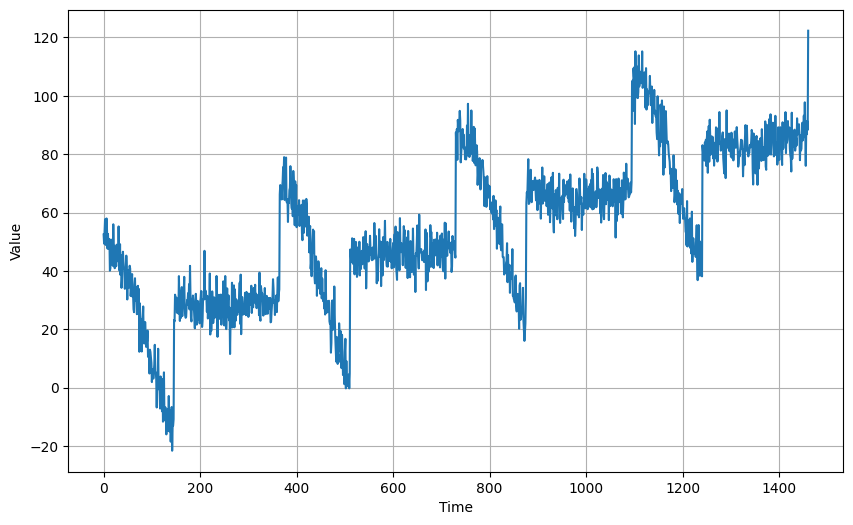

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 13s 28ms/step - loss: 73.2184 - mae: 73.7181 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 72.8925 - mae: 73.3922 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 9ms/step - loss: 72.3650 - mae: 72.8646 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 71.7090 - mae: 72.2087 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 9ms/step - loss: 70.9386 - mae: 71.4382 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 70.0614 - mae: 70.5608 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 69.0693 - mae: 69.5687 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 67.9513 - mae: 68.4507 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 12ms/step - loss: 66.6949 - mae: 67.1944 - lr: 2.511

(1e-08, 0.0001, 0.0, 30.0)

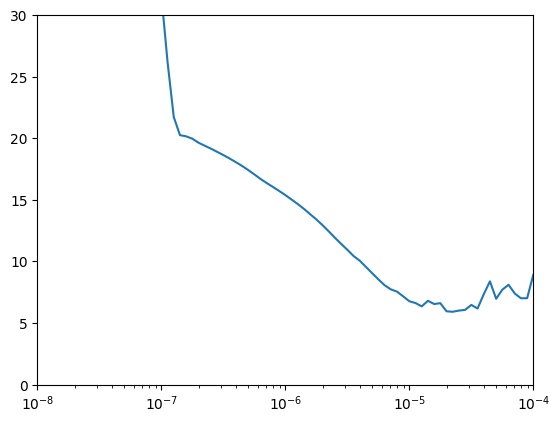

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 5s 163ms/step - loss: 670.3063 - mae: 670.8063 - val_loss: 1008.4810 - val_mae: 1008.9809
Epoch 2/500
7/8 [=========================>....] - ETA: 0s - loss: 562.3131 - mae: 562.8131

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 23ms/step - loss: 598.4130 - mae: 598.9129 - val_loss: 983.8592 - val_mae: 984.3592
Epoch 3/500
8/8 [==============================] - 0s 35ms/step - loss: 598.7225 - mae: 599.2225 - val_loss: 973.2582 - val_mae: 973.7582
Epoch 4/500
8/8 [==============================] - 0s 25ms/step - loss: 599.5616 - mae: 600.0616 - val_loss: 968.6866 - val_mae: 969.1866
Epoch 5/500
8/8 [==============================] - 0s 22ms/step - loss: 598.5294 - mae: 599.0294 - val_loss: 966.7102 - val_mae: 967.2102
Epoch 6/500
8/8 [==============================] - 0s 23ms/step - loss: 599.4282 - mae: 599.9282 - val_loss: 965.8514 - val_mae: 966.3515
Epoch 7/500
8/8 [==============================] - 0s 24ms/step - loss: 598.9031 - mae: 599.4031 - val_loss: 965.4741 - val_mae: 965.9740
Epoch 8/500
8/8 [==============================] - 0s 35ms/step - loss: 599.5584 - mae: 600.0585 - val_loss: 965.3038 - val_mae: 965.8038
Epoch 9/500
8/8 [=============================

In [9]:
model = keras.models.load_model("my_checkpoint.h5")

In [10]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

45/45 [==============================] - 1s 7ms/step


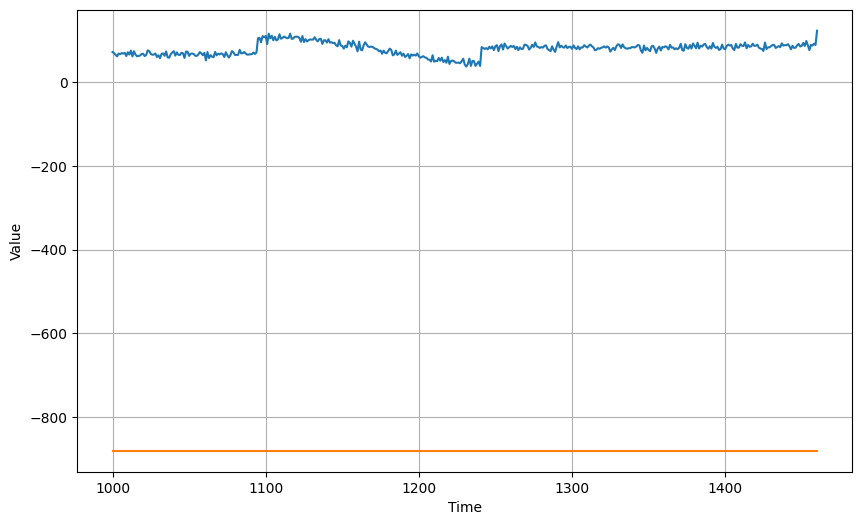

In [11]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [12]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

958.09595

## Fully Convolutional Forecasting

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 80ms/step - loss: 42.8610 - mae: 43.3599 - lr: 1.0000e-04
Epoch 2/100
8/8 [==============================] - 0s 8ms/step - loss: 42.5402 - mae: 43.0390 - lr: 1.0798e-04
Epoch 3/100
8/8 [==============================] - 0s 8ms/step - loss: 42.2378 - mae: 42.7366 - lr: 1.1659e-04
Epoch 4/100
8/8 [==============================] - 0s 9ms/step - loss: 41.9576 - mae: 42.4565 - lr: 1.2589e-04
Epoch 5/100
8/8 [==============================] - 0s 8ms/step - loss: 41.7132 - mae: 42.2121 - lr: 1.3594e-04
Epoch 6/100
8/8 [==============================] - 0s 9ms/step - loss: 41.4619 - mae: 41.9609 - lr: 1.4678e-04
Epoch 7/100
8/8 [==============================] - 0s 9ms/step - loss: 41.0848 - mae: 41.5840 - lr: 1.5849e-04
Epoch 8/100
8/8 [==============================] - 0s 12ms/step - loss: 40.4808 - mae: 40.9800 - lr: 1.7113e-04
Epoch 9/100
8/8 [==============================] - 0s 8ms/step - loss: 39.5195 - mae: 40.0183 - lr: 1.8478e-04

(0.0001, 0.1, 0.0, 30.0)

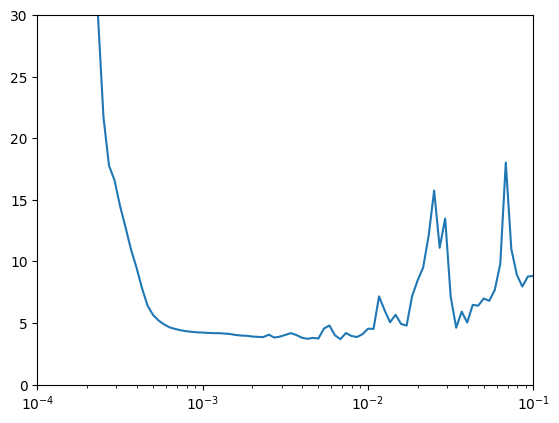

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(learning_rate=3e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[model_checkpoint])

Epoch 1/500
8/8 [==============================] - 4s 165ms/step - loss: 39.2463 - mae: 39.7452 - val_loss: 64.8120 - val_mae: 65.3120
Epoch 2/500
8/8 [==============================] - 0s 36ms/step - loss: 28.3703 - mae: 28.8681 - val_loss: 26.7086 - val_mae: 27.2034
Epoch 3/500
8/8 [==============================] - 0s 34ms/step - loss: 16.6439 - mae: 17.1378 - val_loss: 23.7197 - val_mae: 24.2153
Epoch 4/500
8/8 [==============================] - 1s 41ms/step - loss: 12.1438 - mae: 12.6341 - val_loss: 17.2855 - val_mae: 17.7808
Epoch 5/500
8/8 [==============================] - 1s 44ms/step - loss: 8.7256 - mae: 9.2116 - val_loss: 9.4566 - val_mae: 9.9400
Epoch 6/500
8/8 [==============================] - 1s 67ms/step - loss: 7.4755 - mae: 7.9600 - val_loss: 9.1091 - val_mae: 9.5943
Epoch 7/500
8/8 [==============================] - 0s 35ms/step - loss: 6.5761 - mae: 7.0583 - val_loss: 7.9782 - val_mae: 8.4617
Epoch 8/500
8/8 [==============================] - 0s 26ms/step - loss: 5

In [16]:
model = keras.models.load_model("my_checkpoint.h5")

In [17]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

44/44 [==============================] - 1s 11ms/step


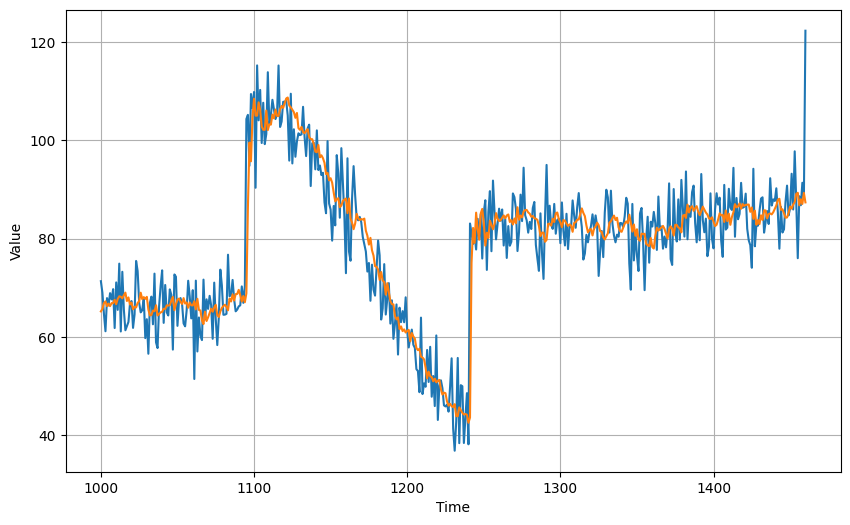

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [19]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.569842